# Variational Autoencoder (VAE)

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset (LFW) (http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [856]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
from torchvision import utils

%matplotlib inline

**Collab setting**

In [ ]:
# if you're running in colab,
# 1. go to Runtime -> Change Runtimy Type -> GPU
# 2. uncomment this:
#!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/hw3_19/homework03/lfw_dataset.py -O lfw_dataset.py

In [904]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
data,attrs = fetch_lfw_dataset(dimx=36,dimy=36)


In [905]:
data = data/255
np.savez("real.npz", Pictures=data.reshape(data.shape[0], 36*36*3))

In [906]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 3888)
(3143, 3888)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [907]:
X_train = np.float32(X_train)
X_val = np.float32(X_val)

In [6]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(2.1 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

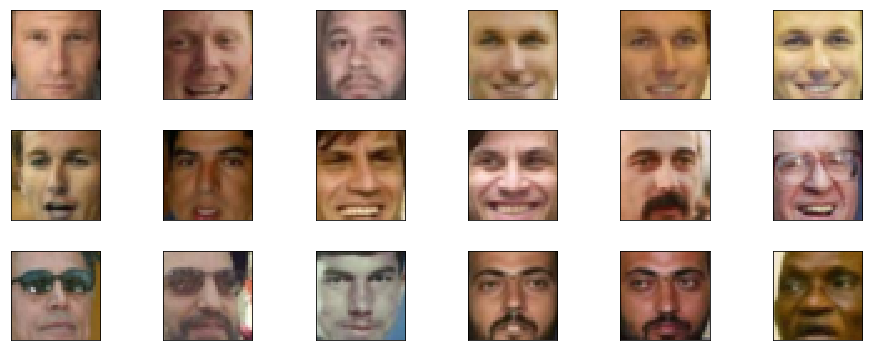

In [7]:
plot_gallery(X_train, image_h, image_w)

In [908]:
 # pseudo labels needed to define TensorDataset
train = data_utils.TensorDataset(torch.Tensor(X_train), torch.zeros(X_train.shape[0],))
train_loader = data_utils.DataLoader(train, batch_size=100, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(X_val), torch.zeros(X_val.shape[0],))
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=False)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="Autoencoder_structure.png" alt="Autoencoder">

In [9]:
dimZ = 100 # Considering face reconstruction task, which size of representation seems reasonable?

# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Linear(3888, dimZ, bias=True),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(dimZ, 3888, bias=True),
            nn.Sigmoid()
        )
        self.encoder.apply(init_weights)
        self.decoder.apply(init_weights)
        
    def forward(self, x):
        
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        
        return reconstruction, latent_code

In [10]:
# Create MSE loss function
criterion = torch.nn.MSELoss()
# Create the model
autoencoder = Autoencoder().cuda()
# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters())

model = {
    'net' : autoencoder,
    'criterion' : criterion,
    'optimizer' : optimizer
}

In [11]:
def train(model, train_loader, val_loader, num_epoch=32):
    
    for i, (putin, y) in enumerate(val_loader):
        if i == 2754:
            break
        
    losses = []
    val_progress = []
    
    for epoch in range(num_epoch):
        # Train
        for (batch, labels) in train_loader:
            pred, _ = model['net'](batch.cuda())
            loss = model['criterion'](pred, batch.cuda())
            loss.backward()
            losses.append(loss.detach().cpu().numpy())
            model['optimizer'].step()
            model['optimizer'].zero_grad()
        print("#%i, Train loss: %.7f"%(epoch+1,np.mean(losses)),flush=True)
        # Save progress of validation image
        with torch.no_grad():
            image, _ = model['net'](putin.cuda())
            val_progress.append(image.cpu())
            
    return val_progress

In [12]:
image_progress = train(model, train_loader, val_loader, 50)

#1, Train loss: 0.0244149
#2, Train loss: 0.0198057
#3, Train loss: 0.0175927
#4, Train loss: 0.0162150
#5, Train loss: 0.0152202
#6, Train loss: 0.0144558
#7, Train loss: 0.0138175
#8, Train loss: 0.0133068
#9, Train loss: 0.0128950
#10, Train loss: 0.0125264
#11, Train loss: 0.0122171
#12, Train loss: 0.0119412
#13, Train loss: 0.0117012
#14, Train loss: 0.0114839
#15, Train loss: 0.0112828
#16, Train loss: 0.0110980
#17, Train loss: 0.0109293
#18, Train loss: 0.0107819
#19, Train loss: 0.0106385
#20, Train loss: 0.0105062
#21, Train loss: 0.0103957
#22, Train loss: 0.0102820
#23, Train loss: 0.0101729
#24, Train loss: 0.0100706
#25, Train loss: 0.0099755
#26, Train loss: 0.0098863
#27, Train loss: 0.0098002
#28, Train loss: 0.0097178
#29, Train loss: 0.0096448
#30, Train loss: 0.0095695
#31, Train loss: 0.0094974
#32, Train loss: 0.0094283
#33, Train loss: 0.0093630
#34, Train loss: 0.0093026
#35, Train loss: 0.0092434
#36, Train loss: 0.0091845
#37, Train loss: 0.0091273
#38, Train

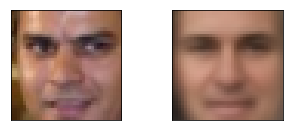

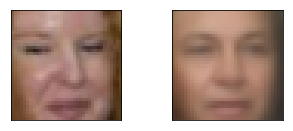

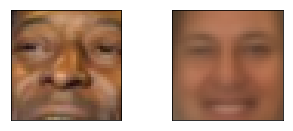

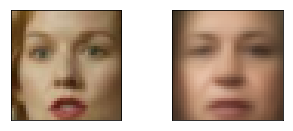

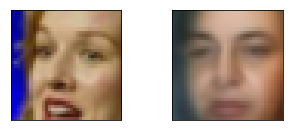

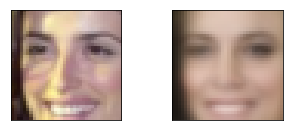

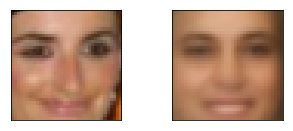

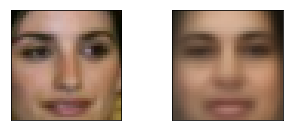

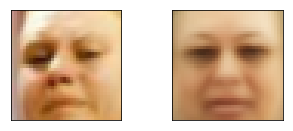

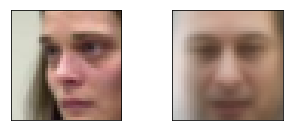

In [13]:
# Examine the reconstructions
for j, data in enumerate(val_loader, 0):
    inp = Variable(data[0].cuda())
    pred, _ = autoencoder(inp)
    plot_gallery([data[0].numpy(), pred.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

Reconstruction is not bad, right? 

# Sampling

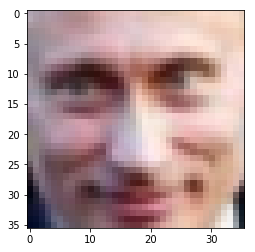

In [14]:
for i, (putin, y) in enumerate(val_loader):
    if i == 2754:
        break
plt.imshow(putin.numpy().reshape((image_w, image_w, 3)))

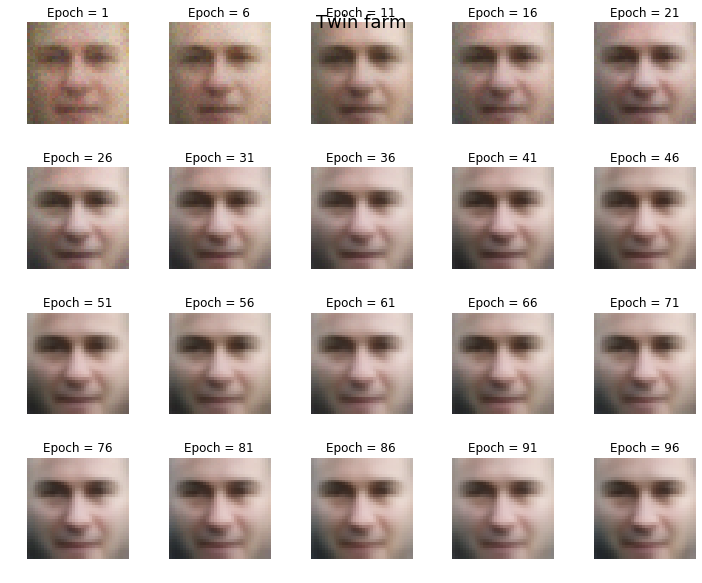

In [15]:
plt.figure(figsize=(10, 12))
plt.suptitle('Twin farm', size=18)
for i in range(len(image_progress[:20])):
    plt.subplots_adjust(bottom=.0, left=.1, right=.9, top=.10, hspace=.15)
    plt.subplot(6, 5, 5*(i//5) + i % 5 + 1)
    plt.imshow(image_progress[i].clamp(0,1).data.cpu().numpy().reshape(image_w, image_h, 3))
    plt.title('Epoch = {}'.format(i * 5 + 1))
    plt.axis('off')
plt.tight_layout()

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

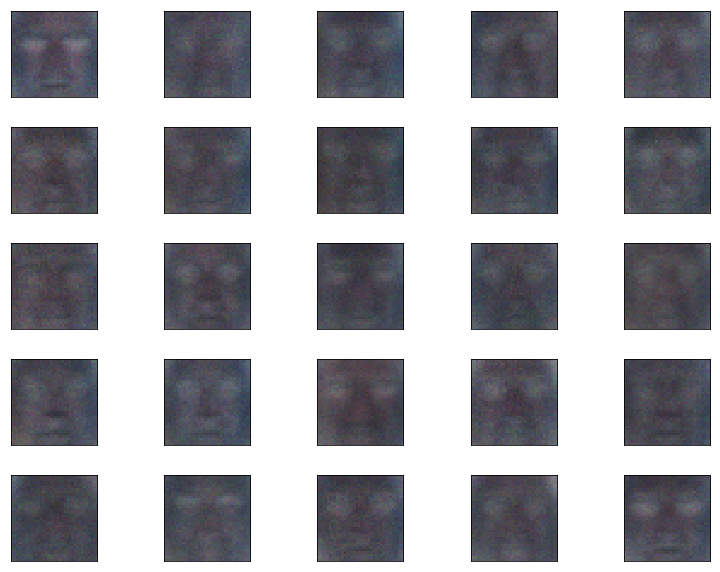

In [16]:
z = (np.random.randn(25, dimZ)*0.5).astype('float32')
output = autoencoder.decoder(Variable(torch.from_numpy(z)).cuda()).clamp(0, 1)
plot_gallery(output.data.cpu().numpy(), image_h, image_w, n_row=5, n_col=5)

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [706]:
class VAE_lin(nn.Module):
    def __init__(self, code_size):
        super(VAE_lin, self).__init__()
        
        self.enc = nn.Sequential(
            nn.Linear(3*36*36, 36*36),
            nn.ReLU(),
            nn.Linear(36*36, 36*3),
            nn.ReLU()
        )
        
        self.enc_fc1 = nn.Linear(36*3, code_size) 
        self.enc_fc2 = nn.Linear(36*3, code_size)
        
        self.dec = nn.Sequential(
            nn.Linear(code_size, 36*3),
            nn.ReLU(),
            nn.Linear(36*3, 36*36),
            nn.ReLU()
        )
        
        self.dec_fc1 = nn.Linear(36*36, 3*36*36)
        self.dec_fc2 = nn.Linear(36*36, 3*36*36)
                
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = logsigma.exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def eval(self):
        self.training = False
        
    def train(self):
        self.training = True
        
    def forward(self, x):
        enc_out = self.enc(x)
        latent_mu = self.enc_fc1(enc_out)
        latent_logsigma = self.enc_fc2(enc_out)
        code = self.gaussian_sampler(latent_mu, latent_logsigma)
        dec_out = self.dec(code)
        reconstruction_mu = self.dec_fc1(dec_out).sigmoid()
        reconstruction_logsigma = self.dec_fc2(dec_out)
        
        return reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

For better numerical stability

In [837]:
def KL_divergence(mu, logsigma):
    return - (1.0 + 2.0*logsigma - mu.pow(2.0) - torch.exp(2.0 * logsigma)).sum() / 2.0

# It turned out, that the model cannot be optimized due to large values of log_likelihood, so
# scale down it manually
def log_likelihood(x, mu, logsigma): 
    exp = -1.0 * (mu - x).pow(2.0) / (2.0 * (torch.exp(logsigma).pow(2)))
    return torch.sum(exp - torch.log(np.sqrt(2.0 * np.pi) * logsigma.exp())) * 0.00001

def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    arg1 = KL_divergence(mu_z, logsigma_z)
    arg2 = log_likelihood(x, mu_gen, logsigma_gen)
    return arg1, arg2, arg1 - arg2

And train the model:

In [816]:
# Create the model
autoencoder = VAE_lin(code_size=dimZ).cuda()
# Use Adammax optimizer
optimizer = optim.Adamax(autoencoder.parameters(), lr=0.001)

model = {
    'net' : autoencoder,
    'criterion' : loss_vae,
    'optimizer' : optimizer
}

In [815]:
def train(model, train_loader, val_loader, num_epoch=40):
    
    train_loss = np.empty(0)
    val_loss = np.empty(0)
    
    kbl, ll = 0,0
    for epoch in range(num_epoch):
        # Train loss
        model['net'].train()
        for (batch, labels) in train_loader:
            #print(batch.shape)
            mu_gen, logsigma_gen, mu_z, logsigma_z = model['net'](batch.cuda())
            #print(mu_gen.shape, logsigma_gen.shape, mu_z.shape, logsigma_z.shape)
            kbl, ll, loss = model['criterion'](batch.cuda(), mu_gen, logsigma_gen, mu_z, logsigma_z)
            loss.backward()
            train_loss = np.append(train_loss, loss.detach().cpu().numpy())
            model['optimizer'].step()
            model['optimizer'].zero_grad()
        print("#%i, Train loss: %.7f"%(epoch+1,np.mean(train_loss)),flush=True)
        print("kbl %.7f, ll %.7f" % (kbl, ll))
        # Validation loss
        if (epoch % 10):
            continue
        model['net'].eval()
        with torch.no_grad():
            for (batch, labels) in val_loader:
                mu_gen, logsigma_gen, mu_z, logsigma_z = model['net'](batch.cuda())
                kbl, ll, loss = model['criterion'](batch.cuda(), mu_gen, logsigma_gen, mu_z, logsigma_z)
                val_loss = np.append(val_loss, loss.detach().cpu().numpy())
            print("#%i, Validation loss: %.7f"%(epoch+1,np.mean(val_loss)),flush=True)
            
    return train_loss, val_loss

150 epochs are enough, if you try to go with 300 you will end up with dead neurons

In [817]:
EPOCHS = 150
train_loss_history, val_loss_history = train(model, train_loader, val_loader, EPOCHS)

#1, Train loss: 4253.6587355
kbl 16.8866577, ll 1.6130486
#1, Validation loss: 555.0698959
#2, Train loss: 2129.2090674
kbl 2.0699368, ll 1.8414496
#3, Train loss: 1419.4365717
kbl 1.6786799, ll 2.1559176
#4, Train loss: 1064.3311290
kbl 0.7835335, ll 2.3371234
#5, Train loss: 851.2221963
kbl 0.7321699, ll 2.2704349
#6, Train loss: 709.1369090
kbl 1.1551402, ll 2.4542580
#7, Train loss: 607.6499133
kbl 0.6096988, ll 2.2200878
#8, Train loss: 531.5330242
kbl 0.9181287, ll 2.4052441
#9, Train loss: 472.3104401
kbl 1.2064803, ll 2.2892203
#10, Train loss: 424.9293045
kbl 0.7967721, ll 2.2636747
#11, Train loss: 386.1806039
kbl 0.6211965, ll 2.3258181
#11, Validation loss: 734.1020859
#12, Train loss: 353.8790126
kbl 0.9196316, ll 2.2752688
#13, Train loss: 326.5867740
kbl 0.8871247, ll 1.9612212
#14, Train loss: 303.1482969
kbl 0.5089020, ll 2.2266209
#15, Train loss: 282.8649862
kbl 0.6149642, ll 2.4324880
#16, Train loss: 265.0959039
kbl 0.8767105, ll 2.3507996
#17, Train loss: 249.4010

kbl 0.1779673, ll 3.7242358
#138, Train loss: 28.4751025
kbl 0.1813780, ll 3.5850403
#139, Train loss: 28.2439521
kbl 0.1479211, ll 3.7227156
#140, Train loss: 28.0162809
kbl 0.1394418, ll 3.9862731
#141, Train loss: 27.7917432
kbl 0.1815769, ll 3.0636497
#141, Validation loss: 855.8519818
#142, Train loss: 27.5701514
kbl 0.1414392, ll 3.8693614
#143, Train loss: 27.3518221
kbl 0.1517695, ll 3.7878978
#144, Train loss: 27.1362675
kbl 0.1327721, ll 3.9203227
#145, Train loss: 26.9235081
kbl 0.1221961, ll 4.0289660
#146, Train loss: 26.7137516
kbl 0.1352340, ll 3.6095271
#147, Train loss: 26.5068250
kbl 0.1264606, ll 3.8305635
#148, Train loss: 26.3029371
kbl 0.1492028, ll 3.6302981
#149, Train loss: 26.1015165
kbl 0.1412564, ll 3.9268739
#150, Train loss: 25.9023550
kbl 0.1363248, ll 3.6529694


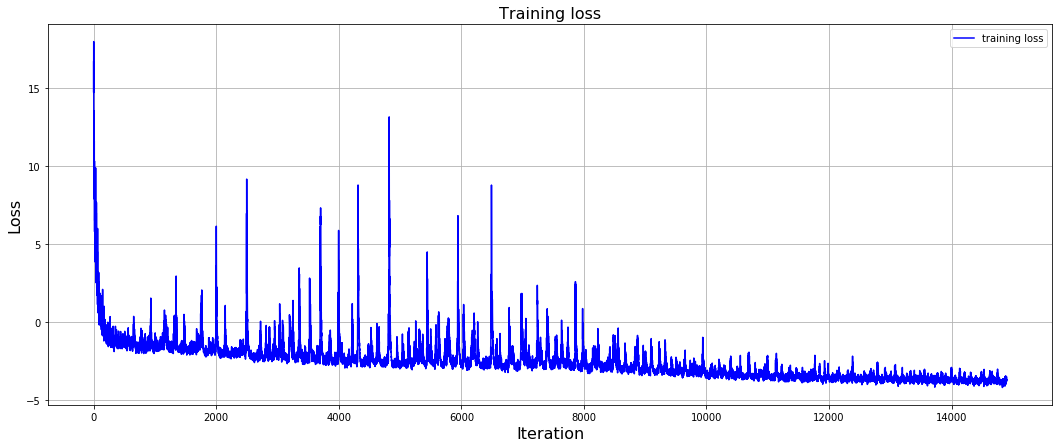

In [822]:
plt.figure(figsize=(18, 7))
plt.title("Training loss", size=16)
plt.xlabel("Iteration", size=16)
plt.ylabel("Loss", size=16)
plt.plot(train_loss_history[100::], 'b', label="training loss")
plt.legend()
plt.grid()
plt.show()

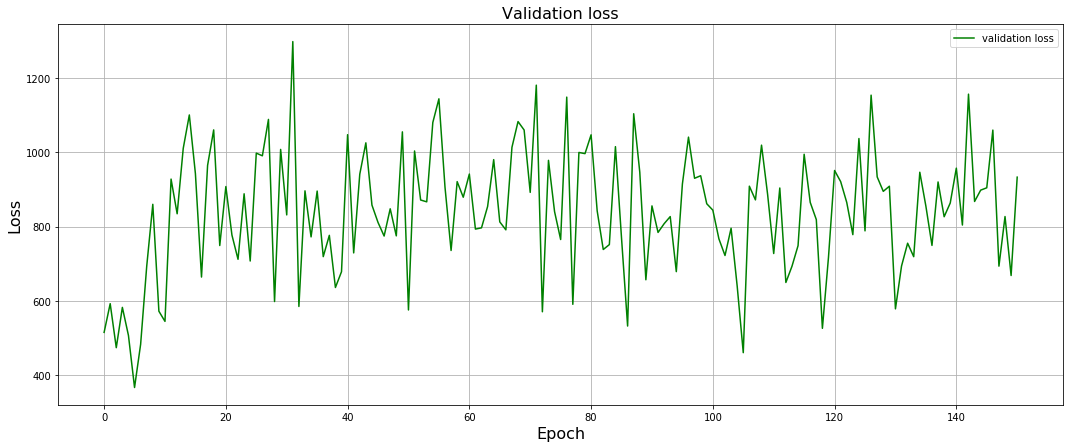

In [823]:
plt.figure(figsize=(18, 7))
plt.title("Validation loss", size=16)
plt.xlabel("Epoch", size=16)
plt.ylabel("Loss", size=16)
plt.plot(val_loss_history[::int(len(val_loss_history)/EPOCHS)], 'g', label="validation loss")
plt.legend()
plt.grid()
plt.show()

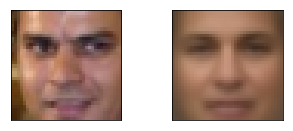

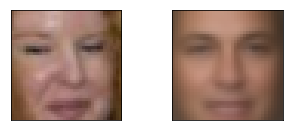

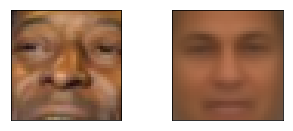

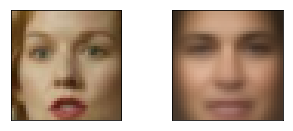

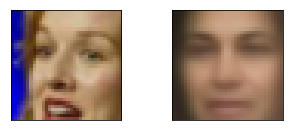

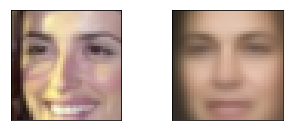

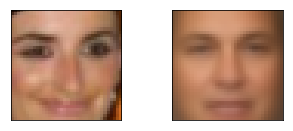

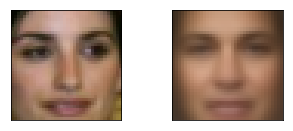

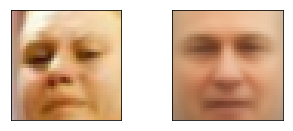

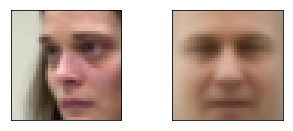

In [851]:
vae = model['net']
# Examine the reconstructions
#val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=True)
vae.eval()
for j, data in enumerate(val_loader, 0):
    input = Variable(data[0].cuda())
    reconstruction_mu, _, _, _ = vae(input)
    plot_gallery([data[0].numpy(), reconstruction_mu.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

And finally sample from VAE.

In [927]:
import tqdm

random_imgs = []
reconstructed_imgs = []

with torch.no_grad():
    for i in tqdm.trange(len(data)):
        # 1) Sample z ~ N(0,1)
        random_code = torch.normal(mean=torch.zeros((1, dimZ)),\
                                   std=torch.ones((1, dimZ))).cuda()
        
        mu_gen = vae.dec_fc1(vae.dec(random_code)).sigmoid()
        logsigma_gen =  vae.dec_fc2(vae.dec(random_code))

        # 2) Sample from N(decoder_mu(z), decoder_sigma(z))
        img = torch.normal(mu_gen, torch.exp(logsigma_gen))
        reconstructed, _, _, _ = vae(img)

        random_imgs.append(mu_gen.view(36, 36, 3).permute(2,0,1))
        reconstructed_imgs.append(reconstructed.view(36, 36, 3).permute(2,0,1))

100%|██████████| 13143/13143 [00:11<00:00, 1179.95it/s]


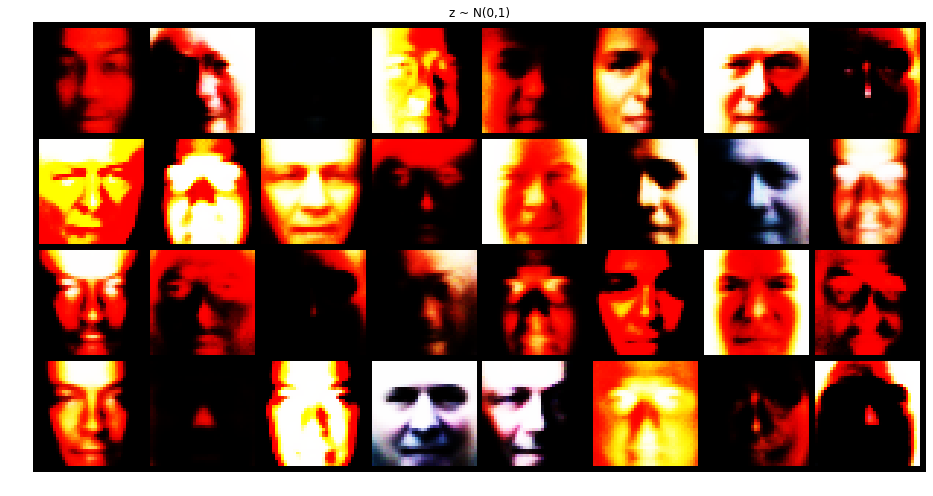

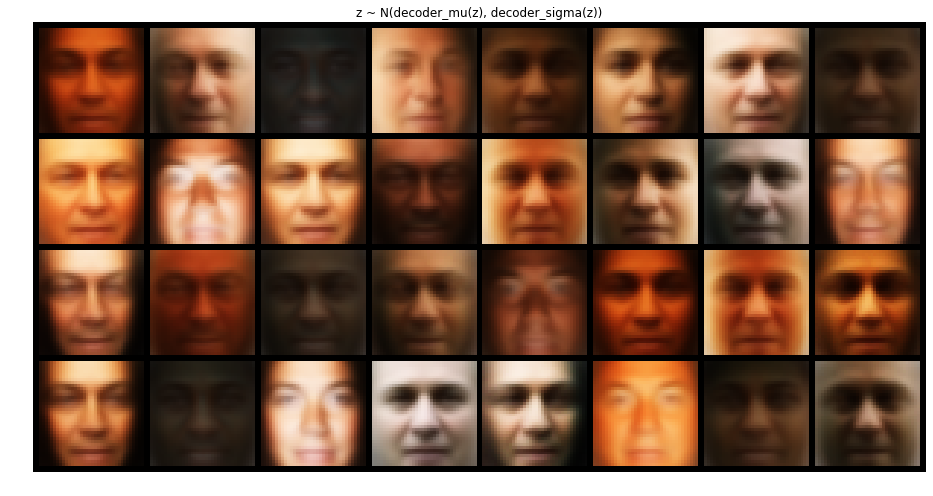

In [940]:
batch = np.random.randint(low=0, high=(len(data) - 1), size=32)

plt.figure(figsize=(16,10))
plt.title("z ~ N(0,1)")
plt.axis("off")
plt.imshow(utils.make_grid([random_imgs[i] for i in batch]).permute(1,2,0).cpu().numpy())
plt.show()

plt.figure(figsize=(16,10))
plt.title("z ~ N(decoder_mu(z), decoder_sigma(z))")
plt.axis("off")
plt.imshow(utils.make_grid([reconstructed_imgs[i] for i in batch]).permute(1,2,0).cpu().numpy())
plt.show()

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

## If you are going to do part 4 (presicion-recall score): 

In [943]:
# using your model, generate face set with len = len(data)
answ = [i.permute(1,2,0).view(3*36*36) for i in reconstructed_imgs]

## Save it ot npz

In [944]:
np.savez("vae.npz", Pictures=answ)

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

<img src="linear.png" alt="linear">